#Load in Files

### Imports

In [1]:
spark.version

u'2.2.0'

In [32]:
import re
import datetime
from pyspark.sql.functions import *
import pandas as pd
pd.set_option('display.max_colwidth', 130)

import matplotlib.pyplot as plt

### Load In NBA Score Data Set

In [33]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType,DateType

cleaned_dir = '/data2/nba-rt-prediction/sparkfiles/cleanedDF'
df = spark.read.format('csv')\
                    .option("header", "true")\
                    .option("inferSchema", "true")\
                    .option("dateFormat", "yyyy-MM-dd")\
                    .load(cleaned_dir).coalesce(2)

# Here use Pandas Dataframes as visualization needs to run in the driver
# downsample if necessary
visdf = df.toPandas()
visdf[0:9]

,dateOrig,ts,teamlonga,scorea,teamlongb,scoreb,timestring,timeleft,gameid,teama,...,overunder,teamaml,teamlongh,teamh,teamhml,dateStr,key,fscorea,fscoreb,win-loss-enc
0,2016-04-20,00:01:44,Memphis,68,San Antonio,94,(0:00 IN 4TH),0.000000,400874376,mem,...,187,-110,San Antonio,san,-110,2016-04-19,2016-04-19.mem.san,68,94,0
1,2016-04-20,00:00:13,Memphis,66,San Antonio,94,(0:42 IN 4TH),0.700000,400874376,mem,...,187,-110,San Antonio,san,-110,2016-04-19,2016-04-19.mem.san,68,94,0
2,2016-04-19,23:59:43,Memphis,66,San Antonio,94,(0:56 IN 4TH),0.933333,400874376,mem,...,187,-110,San Antonio,san,-110,2016-04-19,2016-04-19.mem.san,68,94,0
3,2016-04-19,23:59:13,Memphis,66,San Antonio,92,(1:28 IN 4TH),1.466667,400874376,mem,...,187,-110,San Antonio,san,-110,2016-04-19,2016-04-19.mem.san,68,94,0
4,2016-04-19,23:51:41,Memphis,63,San Antonio,88,(3:17 IN 4TH),3.283333,400874376,mem,...,187,-110,San Antonio,san,-110,2016-04-19,2016-04-19.mem.san,68,94,0
5,2016-04-19,23:51:11,Memphis,63,San Antonio,83,(3:57 IN 4TH),3.950000,400874376,mem,...,187,-110,San Antonio,san,-110,2016-04-19,2016-04-19.mem.san,68,94,0
6,2016-04-19,23:50:40,Memphis,63,San Antonio,83,(4:15 IN 4TH),4.250000,400874376,mem,...,187,-110,San Antonio,san,-110,2016-04-19,2016-04-19.mem.san,68,94,0
7,2016-04-19,23:49:10,Memphis,63,San Antonio,82,(5:35 IN 4TH),5.583333,400874376,mem,...,187,-110,San Antonio,san,-110,2016-04-19,2016-04-19.mem.san,68,94,0
8,2016-04-19,23:45:38,Memphis,61,San Antonio,82,(5:58 IN 4TH),5.966667,400874376,mem,...,187,-110,San Antonio,san,-110,2016-04-19,2016-04-19.mem.san,68,94,0


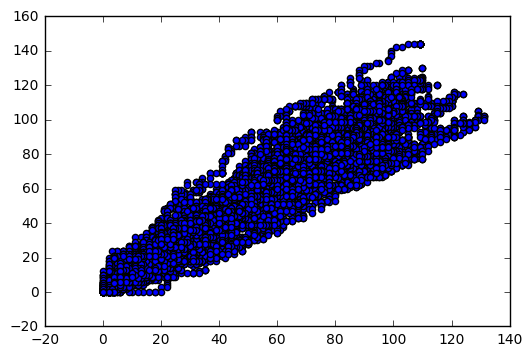

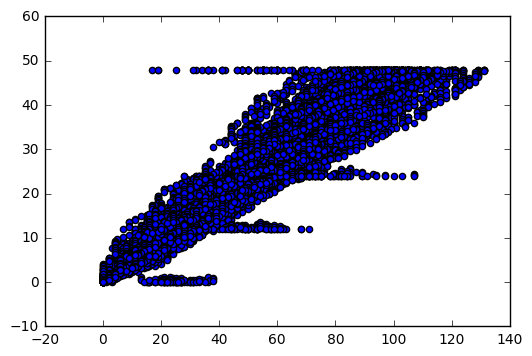

In [36]:
### Show the average number of points per game in a histogram
#visdf.describe()

plt.scatter(visdf["scorea"].values,visdf["scoreb"].values)
plt.show()
plt.scatter(visdf["scorea"].values,48-visdf["timeleft"].values)
plt.show()

In [14]:
visdf.groupby("key").take(10)

""


In [66]:
rtscoresAndFinalDF.filter(rtscoresAndFinalDF.timestring.contains("FINAL")).show(5)
rtscoresAndFinalDF.filter(rtscoresAndFinalDF.timestring.contains("1ST")).show(5)

+----------+--------+-----------+------+------------+------+----------+--------+---------+
|  dateOrig|      ts|  teamlonga|scorea|   teamlongb|scoreb|timestring|timeleft|   gameid|
+----------+--------+-----------+------+------------+------+----------+--------+---------+
|2016-04-05|21:22:09|New Orleans|    93|Philadelphia|   107|   (FINAL)|     0.0|400829041|
|2016-04-05|22:08:42|  Charlotte|    90|     Toronto|    96|   (FINAL)|     0.0|400829043|
|2016-04-05|22:25:25|    Chicago|    92|     Memphis|   108|   (FINAL)|     0.0|400829045|
|2016-04-05|22:28:58|    Phoenix|    90|     Atlanta|   103|   (FINAL)|     0.0|400829044|
|2016-04-05|22:30:29|  Cleveland|   109|   Milwaukee|    80|   (FINAL)|     0.0|400829046|
+----------+--------+-----------+------+------------+------+----------+--------+---------+
only showing top 5 rows

+----------+--------+-----------+------+------------+------+-------------+-------------+---------+
|  dateOrig|      ts|  teamlonga|scorea|   teamlongb|scor

### UDFs For Creating Extra Columns In Real Time Data Frame

In [67]:
# Create new team name column.. do simple lookup conversion with a UDF
def mapper(teamin) :
    return teamMap[teamin]

mapperudf = udf(mapper)


In [73]:
# Date Logic to adjust for games that finish on the day after .... 
# This is so that I can join them against the spread which was dated the day prior...
# This is due to not having a great key to join my tables ...

datecrossregex = re.compile("^0[0-3]") # midnight to 3am
def dateadjust(datein, tsin ) : 
    #dateary = datein.split("-")
    tsary   = tsin.split(":")
    sub_one_day = datetime.timedelta(days=1)
    newdate = datein
    if datecrossregex.match(tsary[0]) :
        #day = "%02d".format(int(dateary[2]) -1)
        #newdate = dateary(0) + "-" + dateary(1) + "-" + day   
        newdate = datein - sub_one_day
    return str(newdate)

dateadjustudf = udf(dateadjust)


# UDFs to create some extra features ... this one is for an experiemental combination of Time left and Score difference.  
# Made this via intuition.  This can be extended to add other custom features
import math
def scoredivtimeXform(numerator, denominator):
    rv = numerator/(math.pow(denominator+1,0.5))
    return rv
scoredivtimeUdf = udf(scoredivtimeXform)


### Wrangle The Real Time And Final Score Data.  Add Columns To The Data Set

In [74]:
# Remove Overtime games from this analysis
rtscoresAndFinalDF = rtscoresAndFinalDF.filter(~col("timestring").like("%OT%"))
# Create short 3 character team names 
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("teama", mapperudf(col("teamlonga")))
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("teamb", mapperudf(col("teamlongb")))



In [75]:
# Add a score differential Column 
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("scorea-scoreb", col("scorea") - col("scoreb"))

# Transform the Date.  This is for games that spanned multiple days and gave me a headache.  
# Games adjusted to the day they started on.
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("date",  dateadjustudf(col("dateOrig"),col("ts")))

# Create a Key for me to use to join with my odds data later.  Key = date.teama.teamb
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("key", concat(col("date"),lit("."),col("teama"),lit("."),col("teamb")))


In [77]:
rtscoresAndFinalDF.show()


+----------+--------+-------------+------+------------+------+-------------+--------+---------+-----+-----+-------------+----------+------------------+
|  dateOrig|      ts|    teamlonga|scorea|   teamlongb|scoreb|   timestring|timeleft|   gameid|teama|teamb|scorea-scoreb|      date|               key|
+----------+--------+-------------+------+------------+------+-------------+--------+---------+-----+-----+-------------+----------+------------------+
|2016-04-05|15:06:16|      Phoenix|     0|     Atlanta|     0| (8:00 PM ET)|    48.0|400829044|  pho|  atl|            0|2016-04-05|2016-04-05.pho.atl|
|2016-04-05|15:06:16|      Chicago|     0|     Memphis|     0| (8:00 PM ET)|    48.0|400829045|  chi|  mem|            0|2016-04-05|2016-04-05.chi.mem|
|2016-04-05|15:06:16|    Cleveland|     0|   Milwaukee|     0| (8:00 PM ET)|    48.0|400829046|  cle|  mil|            0|2016-04-05|2016-04-05.cle.mil|
|2016-04-05|15:06:16|Oklahoma City|     0|      Denver|     0| (9:00 PM ET)|    48.0|400

### Separate The Real Time And Final Data From One Common Dataframe To Two Dataframes

In [174]:
# Currently based on the way the data was sampled, both real time scores and final scores are written as seperate records to the same file.  I need to pull these apart, and then join the dataframes so that I have a real time score and features, and know if the game was won or lost ....

# Create Final Score DF
# Note a shortcut for repeating the dataframe within the filter is to use a $   df.filter(df("foo").contains ... is equiv to df.filter($"foo".contains)

finalscoresDF = rtscoresAndFinalDF.filter(col("timestring").like("%FINAL%"))

# Rename some columns so that join later doesnt have name overlaps
finalscoresDF = finalscoresDF.withColumnRenamed("scorea", "fscorea")
finalscoresDF = finalscoresDF.withColumnRenamed("scoreb", "fscoreb")

# Create final score difference
finalscoresDF = finalscoresDF.withColumn("fscorea-fscoreb", col("fscorea") - col("fscoreb"))

# Add a Win/loss column Win = 1, Loss = 0
finalscoresDF = finalscoresDF.withColumn("win-loss-enc", (when(col("fscorea-fscoreb") > 0.0, 1.0).otherwise(0)))

#(when(df['age'] == 2, 3).otherwise(4)

# Remove Halftime records as this particular case isn't handled well... (for now)
rtscoresDF = rtscoresAndFinalDF.filter(~col("timestring").like("%FINAL%")).filter(~col("timestring").like("HALFTIME"))

# Create final score difference
rtscoresDF = rtscoresDF.withColumn("scorea-scoreb", col("scorea") - col("scoreb"))

# Create a unique feature based on my custom UDF.  Idea here is that I have intuition that timeleft and score difference are a strong predictor when combined
rtscoresDF = rtscoresDF.withColumn("score-div-time", scoredivtimeUdf(col("scorea") - col("scoreb"), col("timeleft")*2))


### Lets Take A Look Of What We Have For The Two Dataframes We Just Wrangled

In [208]:
# Some Printouts .....
print("final scores data frame")
finalscoresDF.show(5)
print("real time scores data frame")
rtscoresDF.show(5)
finalscoresDF.printSchema


print "##########################################"
print "Total Data Points in rtscoresDF = {0}".format(rtscoresDF.count())
print "Total Data Points in rtscoresDF uniq = {0}".format(rtscoresDF.sort("key").distinct().count())
print "Total Data Points in finalscoresDF = {0}".format(finalscoresDF.count())
print "##########################################"




final scores data frame
+----------+--------+-----------+-------+------------+-------+----------+--------+---------+-----+-----+-------------+----------+------------------+---------------+------------+
|  dateOrig|      ts|  teamlonga|fscorea|   teamlongb|fscoreb|timestring|timeleft|   gameid|teama|teamb|scorea-scoreb|      date|               key|fscorea-fscoreb|win-loss-enc|
+----------+--------+-----------+-------+------------+-------+----------+--------+---------+-----+-----+-------------+----------+------------------+---------------+------------+
|2016-04-05|21:22:09|New Orleans|     93|Philadelphia|    107|   (FINAL)|     0.0|400829041|  nor|  phi|          -14|2016-04-05|2016-04-05.nor.phi|            -14|         0.0|
|2016-04-05|22:08:42|  Charlotte|     90|     Toronto|     96|   (FINAL)|     0.0|400829043|  cha|  tor|           -6|2016-04-05|2016-04-05.cha.tor|             -6|         0.0|
|2016-04-05|22:25:25|    Chicago|     92|     Memphis|    108|   (FINAL)|     0.0|4008

### Interpret the Odds data
````How to interpret the odds data ...
Example Golden State -12.5 O (207.0) -125.0 | Detroit 12.5 U (207.0) 145.0
Here Golden State the away team is a 12.5 pt favorite to win.  The over under is in parentheses (207) and is the 50/50 line between teams sum of scores
being above/below that line.  
Finally the -125 / +145 numbers are whats known at the moneyline odds. 
    A negative number means you need to bet 125$ to get a 100$ payout
    A positive number means you need to bet 100$ to get a 145$ payout
```

### Load In Odds Data

In [176]:
# Here, the data is very raw, and needs to be pre-processed .  I will start by loading it as an RDD and perform a lot of transformations.  Once I have it properly parsed, I will convert to a dataframe.
# This is not beautiful, but gets the job done
# Data format .....
#       <title>New Orleans 2.5 O (207.0) 125.0 | Phila. -2.5 U (207.0) -145.0 (Apr 05, 2016 07:10 PM)</title>
#       <title>Detroit 4.0 O (202.0) 160.0 | Miami -4.0 U (202.0) -190.0 (Apr 05, 2016 08:05 PM)</title>
oddsfile = "/data2/nba-rt-prediction/nbaodds_042516.xml"

# Reading the data in as an RDD first.  There isn't a dataframe parser for this XML I have, so I will write a custom parser ....
oddsrdd = spark.read.text(oddsfile).rdd
# just grabbing the text within the < ... > tags.  I can do this, because the format is super simple and not nested
# the subscript [0] is due to the fact that spark.read.text read in the oddsfile of Type Row.  Need to index
# into it to get the string
gameStringRdd = oddsrdd.map(lambda x : x[0][x[0].find('>')+1:x[0].rfind('<')])


In [178]:
#oddsrdd.map(lambda x : x[0].find('>')).take(2)
#gameStringRdd.take(2)

In [232]:
# This is where I do the heavy lifting of parsing my XML .. and then finally convert my RDD to a dataframe .....
# just lots of string parsing and data type conversions
def parseOdds(line_in) : 
    away_str = line_in[0:line_in.find('|')]  
    home_and_date_str = line_in[line_in.find('|')+2:-1]
    home_str = home_and_date_str[0:home_and_date_str.rfind('(')]
    date_str = home_and_date_str[home_and_date_str.rfind('(')+1:len(home_and_date_str)]
    date_str = date_str.replace(',', '')
    
    # parse away string
    overunder = away_str[away_str.find('(')+1:away_str.find(')')]
    teamaml = away_str[away_str.find(')')+2:len(away_str)-1]
    away_str_2 = away_str[0:away_str.find('(')-3]
    teamaspread = away_str_2[away_str_2.rfind(' ')+1:len(away_str_2)]
    teamlonga = away_str_2[0:away_str_2.rfind(' ')]
    teama = teamMap[teamlonga]
    
     # parse home string
    overunder = home_str[home_str.find('(')+1:home_str.find(')')]
    teamhml = home_str[home_str.find(')')+2:len(home_str)-1]
    home_str_2 = home_str[0:home_str.find('(')-3]
    teamhspread = home_str_2[home_str_2.rfind(' ')+1:len(home_str_2)]
    teamlongh = home_str_2[0:home_str_2.rfind(' ')]
    teamh = teamMap[teamlongh]
   
    # parse date string
    dateInfo = date_str.split(' ')
    dateStr = dateInfo[2] + "-" + monthMap[dateInfo[0]] + "-" + dateInfo[1]
    # This will become my join key for the other data sets
    key = dateStr +"." + teama + "." + teamh
    return (key,teamlonga,teama,teamaspread,overunder,teamaml,teamlongh,teamh,teamhml,dateStr)

#def parseOdds(line_in) : 
#    away_str = line_in[0:line_in.find('|')]  
#    return (away_str,away_str)


oddsDF = gameStringRdd.map(lambda x : parseOdds(x))\
        .toDF(["key","teamlonga","teama","teamaspread","overunder","teamaml","teamlongh","teamh","teamhml","dateStr"]).distinct()

# OddsDF has some dups due to the fact that I have multiple readings ...
oddsDF.registerTempTable("odds_table")

oddsDF = spark.sql("SELECT key, FIRST(teamlonga) as teamlonga, FIRST(teama) as teama,\
  AVG(teamaspread) as teamaspread, AVG(overunder) as overunder, AVG(teamaml) as teamaml,\
  FIRST(teamlongh) as teamlongh,FIRST(teamh) as teamh,AVG(teamhml) as teamhml, FIRST(dateStr) as dateStr FROM odds_table GROUP BY key")


In [233]:
#oddsrdd.take(2)
#gameStringRdd.take(2)
print oddsDF.count()
oddsDF.show()
oddsDF.printSchema

111
+------------------+------------+-----+-----------+------------------+-----------------+------------+-----+------------------+----------+
|               key|   teamlonga|teama|teamaspread|         overunder|          teamaml|   teamlongh|teamh|           teamhml|   dateStr|
+------------------+------------+-----+-----------+------------------+-----------------+------------+-----+------------------+----------+
|2016-04-24.atl.bos|     Atlanta|  atl|        1.5|             203.5|              0.0|      Boston|  bos|            -120.0|2016-04-24|
|2016-04-19.mem.san|     Memphis|  mem|      18.25|             187.0|           -110.0| San Antonio|  san|            -110.0|2016-04-19|
|2016-04-26.ind.tor|     Indiana|  ind|        7.0|             192.0|            260.0|     Toronto|  tor|            -320.0|2016-04-26|
|2016-04-13.mia.bos|       Miami|  mia|        5.0|             206.5|            170.0|      Boston|  bos|            -200.0|2016-04-13|
|2016-04-13.sac.hou|  Sacramen

<bound method DataFrame.printSchema of DataFrame[key: string, teamlonga: string, teama: string, teamaspread: double, overunder: double, teamaml: double, teamlongh: string, teamh: string, teamhml: double, dateStr: string]>

### Inspect Some Of The Odds Data

In [235]:
oddsDF.show(5)
print "Total Home Teams      = {0}".format(oddsDF.select("teamh").distinct().count())
print "Total Away Teams      = {0}".format(oddsDF.select("teama").distinct().count())
print "Total Games Collected = {0} ".format(oddsDF.count())


+------------------+----------+-----+-----------+---------+-------+-----------+-----+-------+----------+
|               key| teamlonga|teama|teamaspread|overunder|teamaml|  teamlongh|teamh|teamhml|   dateStr|
+------------------+----------+-----+-----------+---------+-------+-----------+-----+-------+----------+
|2016-04-24.atl.bos|   Atlanta|  atl|        1.5|    203.5|    0.0|     Boston|  bos| -120.0|2016-04-24|
|2016-04-19.mem.san|   Memphis|  mem|      18.25|    187.0| -110.0|San Antonio|  san| -110.0|2016-04-19|
|2016-04-26.ind.tor|   Indiana|  ind|        7.0|    192.0|  260.0|    Toronto|  tor| -320.0|2016-04-26|
|2016-04-13.mia.bos|     Miami|  mia|        5.0|    206.5|  170.0|     Boston|  bos| -200.0|2016-04-13|
|2016-04-13.sac.hou|Sacramento|  sac|       15.0|    222.0| -110.0|    Houston|  hou| -110.0|2016-04-13|
+------------------+----------+-----+-----------+---------+-------+-----------+-----+-------+----------+
only showing top 5 rows

Total Home Teams      = 30
Tot

### Join The Odds And Final Score Data Sets

In [236]:
# Here is where we join the Odds/Realtime scores/ Final Scores into one wholistic data set as input for Logistic Machine Learning

# Create a smaller Final Score Dataframe.  Just keep the key, final score a and b, the win/loss indicator
finalslicedscoresDF1 = finalscoresDF.select(["key","fscorea","fscoreb","win-loss-enc"]).distinct()
# First Join the 2 smallest data frames ... odd and final.
gameDF = oddsDF.join(finalslicedscoresDF1, oddsDF["key"] == finalslicedscoresDF1["key"], "inner").drop(oddsDF["key"])
# Drop these redundant columns prior to joining with Realtime score dataframe
gameDF = gameDF.drop("teamlonga")
gameDF = gameDF.drop("teamlongb")
gameDF = gameDF.drop("teama")
gameDF = gameDF.drop("teamb")

In [238]:
# Print Out the Game Dataframe ... notice we have the odds data merged with the win loss data ....
#print("gameDF")
#gameDF.sort(["key"]).show(152)
print "Total finalscoresDF = {0}".format(finalscoresDF.count())
print "Total oddsDF = {0}".format(oddsDF.count())
print "Total Games after joining odds and score data = {0}".format(gameDF.count())

#gameDF.select("key").sort(["key"]).show(144)

finalscoresDF.filter(col("key") == "2016-04-24.gst.hou").show()
oddsDF.filter(col("key") == "2016-04-24.gst.hou").show()


Total finalscoresDF = 116
Total oddsDF = 111
Total Games after joining odds and score data = 101
+----------+--------+------------+-------+---------+-------+----------+--------+---------+-----+-----+-------------+----------+------------------+---------------+------------+
|  dateOrig|      ts|   teamlonga|fscorea|teamlongb|fscoreb|timestring|timeleft|   gameid|teama|teamb|scorea-scoreb|      date|               key|fscorea-fscoreb|win-loss-enc|
+----------+--------+------------+-------+---------+-------+----------+--------+---------+-----+-----+-------------+----------+------------------+---------------+------------+
|2016-04-24|18:29:52|Golden State|    121|  Houston|     94|   (FINAL)|     0.0|400874348|  gst|  hou|           27|2016-04-24|2016-04-24.gst.hou|             27|         1.0|
+----------+--------+------------+-------+---------+-------+----------+--------+---------+-----+-----+-------------+----------+------------------+---------------+------------+

+------------------+--

### Join The Game Dataframe With The Real Time Score Dataframe

In [240]:
lrDF = rtscoresDF.join(gameDF, rtscoresDF["key"] == gameDF["key"], "inner").drop(gameDF["key"])
print("lrDF : Logistic Regression Data Frame")
lrDF.show(3)
print "Total Data Points in rtscoresDF = {0}".format(rtscoresDF.count())
print "Total Data Points in gameDF = {0}".format(gameDF.count())
print "Total Data Points in joined lrDF = {0}".format(lrDF.count())



lrDF : Logistic Regression Data Frame
+----------+--------+---------+------+-----------+------+-------------+--------------+---------+-----+-----+-------------+----------+-------------------+-----------+---------+-------+-----------+-----+-------+----------+------------------+-------+-------+------------+
|  dateOrig|      ts|teamlonga|scorea|  teamlongb|scoreb|   timestring|      timeleft|   gameid|teama|teamb|scorea-scoreb|      date|     score-div-time|teamaspread|overunder|teamaml|  teamlongh|teamh|teamhml|   dateStr|               key|fscorea|fscoreb|win-loss-enc|
+----------+--------+---------+------+-----------+------+-------------+--------------+---------+-----+-----+-------------+----------+-------------------+-----------+---------+-------+-----------+-----+-------+----------+------------------+-------+-------+------------+
|2016-04-20|00:01:44|  Memphis|    68|San Antonio|    94|(0:00 IN 4TH)|           0.0|400874376|  mem|  san|          -26|2016-04-19|              -26.0|  

###Lets Look At Some Stats From 'Unpacked' Logistic Regression Dataframe

In [ ]:
 lrDF.describe().show()

###'Pack' Logistic Dataframe Into Required Format For Logistic Regression [R] - Creating A Simple/Complex Dataframe For Comparison

In [ ]:
# Logistic regression requires that
# The best way I found to modify data in a custom way is with map, however it returns an RDD, so you will need to run toDF at the end
# Logistic DF requires a DF of type  => [label: double, features: vector]

import org.apache.spark.sql._
# These is a helper function that converts an 'Any(Int)' type to a Double or Any(Double) to a Double
val ai2d : (Any => Double) = (in:Any) => in.asInstanceOf[java.lang.Integer].doubleValue
val ad2d : (Any => Double) = (in:Any) => in.asInstanceOf[java.lang.Double]

var nbaSimpleLrDF = lrDF.map {
    dfrow => {
    # get the indexes ... prob should move this out of the looop!
      val tgt = ad2d( dfrow(dfrow.fieldIndex("win-loss-enc")))
      val f1  = ai2d( dfrow(dfrow.fieldIndex("scorea-scoreb")))
      val f2 =  ad2d( dfrow(dfrow.fieldIndex("timeleft")))
      LabeledPoint(tgt,Vectors.dense(f1,f2))
    }
}.toDF("label","features")

var nbaComplexLrDF = lrDF.map {
    dfrow => {
    # get the indexes ... prob should move this out of the looop!
      val tgt = ad2d( dfrow(dfrow.fieldIndex("win-loss-enc")))
      val f1  = ai2d( dfrow(dfrow.fieldIndex("scorea-scoreb")))
      val f2  = ad2d( dfrow(dfrow.fieldIndex("teamaspread")))
      val f3  = ad2d( dfrow(dfrow.fieldIndex("overunder")))
      val f4  = ad2d( dfrow(dfrow.fieldIndex("teamaml")))
      val f5 =  ad2d( dfrow(dfrow.fieldIndex("timeleft")))
      // Add a new feature that weight point differential more as time left gets smaller...
      // I played around with excel and this looked ok ....
      val f6  = ad2d( dfrow(dfrow.fieldIndex("score-div-time")))
      LabeledPoint(tgt,Vectors.dense(f1,f2,f3,f4,f5,f6))
    }
}.toDF("label","features")


nbaSimpleLrDF.show(3)
nbaComplexLrDF.show(3)

### Function to Create The Model And Train It And Test It 

In [ ]:
def trainAndTest( indf : org.apache.spark.sql.DataFrame, modelPath : String ) : (org.apache.spark.sql.DataFrame, org.apache.spark.ml.classification.LogisticRegressionModel)  = {
    val splits = indf.randomSplit(Array(0.60,0.39,0.01), seed = 11L)
    val trainingdf = splits(0).cache()
    val testdf = splits(1).cache()
    val crossvaldf = splits(2).cache()
    
    println("Tranining Samples = " + trainingdf.count())
    println("Test      Samples = " + testdf.count())
    println("Cross Val Samples = " + crossvaldf.count())
    
    # Setup some of the configurations for the Logistic regression model ..
    # Here we could try a pipeline with params to select the 'best setting' but in the interest of time will go with this
    val lr = new LogisticRegression()
      .setMaxIter(50)
    .setRegParam(0.10)
    .setElasticNetParam(0.0)

    # Fit the model
    val lrModel   = lr.fit(trainingdf)

    println("Reg Parameter:    =" + lrModel.getRegParam)
    println("lrModel.intercept = " + lrModel.intercept)
    println("lrModel.weights   = " + lrModel.weights)

    # Save the model for later use ....
    # Argh ! -> in 1.6.1 api, but not 1.5.2 :(  
    # lrModel.save("modelPath" )
    
    ####  Create a logistic regression summary object ////
    # val lrSummary = lrModel.summary
    # println("lrSummary.objectiveHistory = " + lrSummary.objectiveHistory.length)
    # println(lrSummary.objectiveHistory.deep.mkString("\n"))
    ####
    
    # transform is now used in lieu of predict from mllib.  Found this after studying the API for a while
    val predictions = lrModel.transform(testdf)

    # Select (prediction, true label) and compute test error
    val evaluator = new MulticlassClassificationEvaluator()
      .setLabelCol("label")
      .setPredictionCol("prediction")
      .setMetricName("precision")
    
    val accuracy = evaluator.evaluate(predictions)
    println("Test Error = " + (1.0 - accuracy))

    # return the 
    (predictions,lrModel)
}

### Test And Train Multiple Models

In [ ]:
def time[R](block: => R): R = {
  val t0 = System.nanoTime()
  val result = block
  println("Elapsed time: " + (System.nanoTime - t0) + "ns")
  result
 }
 
val (simplePredictionDF, simpleModel)   = trainAndTest(nbaSimpleLrDF, "/data/resources/nbaSimpleModel")
val (complexPredictionDF, complexModel) = trainAndTest(nbaComplexLrDF, "/data/resources/nbaComplexModel")


In [ ]:
complexPredictionDF.show(5)

### Helper To Unpack MLLIB Label and Features Vector Into A Standard Dataframe

In [ ]:
// The whole point to doing this is so that I can visualize the features and the outcomes.  Zeppelin cannot render the Vector type well at all, so converting the data back to a flattened style of layout
// Expect a column name to be passed that is the features vector, all other columns should come back as-is
// I could extend the MLLIB DF to do this !! and  do it



 // Create a Row from values.
// Row(value1, value2, value3, ...)
 // Create a Row from a Seq of values.
// Row.fromSeq(Seq(value1, value2, ...))

// Goal of this function to return a new flattened data frame with the Vector datatype replaced with multiple columns.  This
// is done so that I can use zeppelin to graph my data since it doesnt really handle vectors well for graphing.
// not super flexible as of now, but someday might make it better ...

def convertVectorDF (indf : org.apache.spark.sql.DataFrame, labelIndex : Int, featureIndex : Int, probIndex : Int, predictionIndex : Int) = {

    //indf.select(colname).show(5)
    val myCols = indf.columns
    
    // debug stuff
    println("featureIndex value = " + myCols(featureIndex))
    println("probIndex value = " + myCols(probIndex))
    println("predictionIndex value = " + myCols(predictionIndex))
    
    if(myCols(labelIndex) != "label") {
        println("labelIndex value = " + myCols(labelIndex))
        println("Error")
    }
    
    
    println(" myCols.length = " + myCols.length)
    //println("Vector Size = " + indf[0].features)
    indf.show(3)
    
    // build an RDD of sql Rows here, then use toDF to convert back to a Dataframe..
    val tmprdd = indf.map { line => 
        var reind = 0
        var newRow : Seq[Double]= Seq(line(labelIndex).asInstanceOf[Double])
        var labeledPointVector = line(featureIndex).asInstanceOf[org.apache.spark.mllib.linalg.Vector]
        for(i <- 0 to labeledPointVector.size -1 ) {
            newRow = newRow :+ labeledPointVector(i).asInstanceOf[Double]
        }
        var probArray = line(probIndex).asInstanceOf[org.apache.spark.mllib.linalg.Vector]
        newRow = newRow :+ probArray(0).asInstanceOf[Double]
        newRow = newRow :+ line(predictionIndex).asInstanceOf[Double]
        //  https://spark.apache.org/docs/1.4.0/api/java/org/apache/spark/sql/Row.html see example where 
        //  Row.fromSeq is used to make a Row
        Row.fromSeq(newRow)
    }
    //http://spark.apache.org/docs/latest/sql-programming-guide.html#programmatically-specifying-the-schema
    //val schema =
      // StructType(
      // schemaString.split(" ").map(fieldName => StructField(fieldName, StringType, true)))
    //tmprdd
    //https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/sql/types/StructType.html

    // Take the first row. Each row just has a single 'Row' object at position 0
    val numCols = tmprdd.take(1)(0).length
   //val struct =
    //StructType(
     //StructField("label", IntegerType, true) ::
     //StructField("f1", LongType, false) ::
     //StructField("c", BooleanType, false) :: Nil)
     //sqlContext.createDataFrame(tmprdd,schema)
    var schemaString = myCols(labelIndex);
    for(i <-0 to numCols - 4){
        schemaString = schemaString + ",f" +i 
    }
    schemaString = schemaString + "," + myCols(probIndex);
    schemaString = schemaString + "," + myCols(predictionIndex);
    
    //schemaString = schemaString + tmprdd.take(1)(0).toString
    println(schemaString)
    val schema  = StructType(schemaString.split(",").map(fieldName => StructField(fieldName,DoubleType,true)))
    val finalDF = sqlContext.createDataFrame(tmprdd, schema)
    finalDF
}


###Lets Publish The Model and Analysis And Vizualize In Jupyter ....

In [ ]:
var simpleUnpackedPredictionDF = convertVectorDF(simplePredictionDF,0,1,3,4)
simpleUnpackedPredictionDF = simpleUnpackedPredictionDF.withColumn("correct", when($"label" === $"prediction",1).otherwise(0))

//var complexUnpackedPredictionDF = convertVectorDF(complexPredictionDF,0,1,3,4)
//complexPredictionDF = complexPredictionDF.withColumn("correct", when($"label" === $"prediction",1).otherwise(0))

simpleUnpackedPredictionDF.write.format("json").save("swift://notebooks.spark/test/simple001.json")




In [ ]:
simpleUnpackedPredictionDF.count()

In [ ]:
%AddJar https://github.com/dustinvanstee/random-public-files/raw/master/SystemML.jar
import org.apache.sysml.api.MLContext

In [ ]:
import org.apache.sysml.api.MLContext